##### 설정

In [1]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib 

matplotlib.rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

8장에서 알아본 차원 축소는 가장 널리 사용되는 비지도 학습이다. 이 장에서는 추가적인 비지도 학습 알고리즘을 알아보자.   
1. 군집: 비슷한 샘플을 클러스터로 모은다.
    - 데이터 분석, 고객 분류, 추천 시스템, 검색 엔진, 이미지 분할, 준지도 학습, 차원 축소 등에 사용
2. 이상치 탐지: '정상'데이터가 어떻게 보이는지 학습하고, 비정상 샘플을 탐지하는데 사용.
    - 제조 라인에서 결함 제품 감지, 시계열 데이터에서 새로운 트랜드 발견에 사용
3. 밀도 추정: The random process that generated the dataset의 확률 밀도 함수(PDF, probability density function)을 추정한다.
    - 이상치 탐지에 널리 사용된다. 밀도가 낮은 영역에 놓인 샘플이 이상치일 사능성이 높다.
    - 데이터 분석과 시각화에 유용하다.
    
# 1. 군집(Clustering Algorithms): k-means and DBSCAN
## 1) K-means
: 각 클러스터에 중심을 찾고 가장 가까운 클러스터에 샘플을 할당한다.   
### Hard clustering
⬇︎ blob dataset에 K-means 훈련
- Kmeans의 객체는 훈련된 샘플의 레이블을 보존 -> 샘플의 레이블이란, 샘플이 할당된 클러스터의 예측한 인덱스
- 샘플을 클러스터에 할당할 때 centroid까지 거리를 고려하는 것이 전부이기 때문에, 클러스터의 크기가 크면 알고리즘이 잘 작동하지 않는다.

In [17]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import warnings
warnings.filterwarnings('ignore')

blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                 random_state=7)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

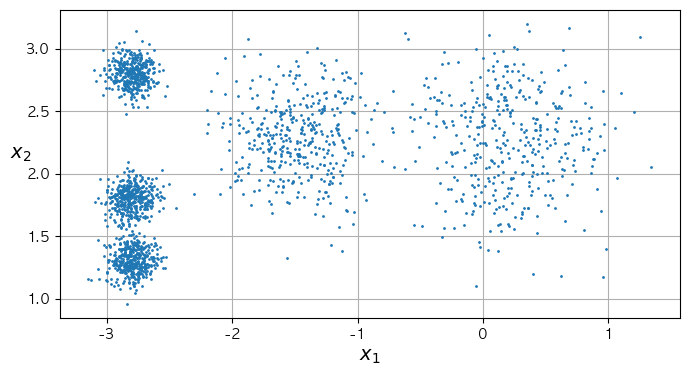

In [18]:
import matplotlib.pyplot as plt
def plot_cluster(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)
    
plt.figure(figsize=(8, 4)) 
plot_cluster(X)
plt.gca().set_axisbelow(True)
plt.grid()
plt.show()

In [24]:
#  각 샘플들이 클러스터에 할당됨
print(len(y_pred))
print("각 샘플의 클러스터 레이블 예측:", y_pred[:10])
print("y_pred is kmeans.labels_ :", y_pred is kmeans.labels_)

2000
각 샘플의 클러스터 레이블 예측: [4 0 1 0 0 4 0 0 3 0]
y_pred is kmeans.labels_ : True


In [23]:
# 5 개의 클러스터 중심 추정
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [29]:
# 새로운 샘플의 레이블 예측
X_new = np.array([[0,-9], [3,4], [-2, 4], [5,9]])
kmeans.predict(X_new)

array([4, 1, 2, 1], dtype=int32)

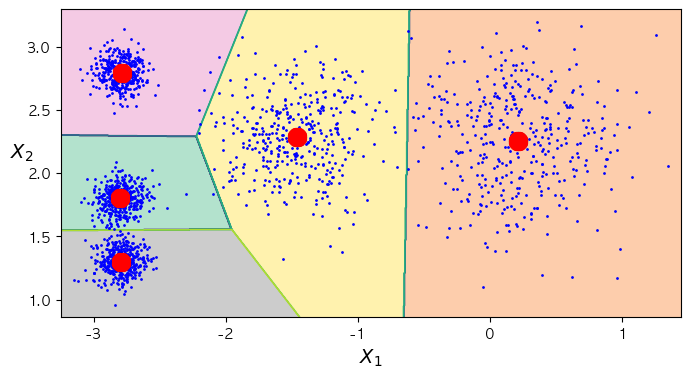

In [42]:
# 모델의 결정 경계 plot
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], "b.", markersize = 2)
    
def plot_centroides(centorids, weights=None, circle_color='k', cross_color='r'):
    if weights is not None:
        centorids = centorids[weights > weights.max() / 10]
    plt.scatter(centorids[:, 0], centorids[:, 1],
               marker='o', s=35, linewidths=8,
               color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centorids[:, 0], centorids[:, 1],
               marker='X', s=35, linewidths=8,
               color=cross_color, zorder=11, alpha=1)
    
def plot_decision_bounderies(clusterer, X, resolution=1000, show_centroids=True,
                            show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, color='k')
    plot_data(X)
    if show_centroids:
        plot_centroides(clusterer.cluster_centers_)
    if show_xlabels:
        plt.xlabel("$X_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$X_2$", rotation=0)
    else:
        plt.tick_params(labelbottom=False)
        
plt.figure(figsize=(8, 4))
plot_decision_bounderies(kmeans, X)
plt.show()

### Soft clustering
: 클러스터마다 샘플에 점수를 부여하는 것. 이때 점수는 샘플과 centroid 사이의 거리. 또는 similarity score가 될 수 있다.
- 샘플을 하나의 클러스터에 할당하는 hard clustering 보다 유용
- `Kmeans`클래스의 `transform()` 메서드는 샘플과 각 centroid 사이의 거리를 반환

In [46]:
X_new

array([[ 0, -9],
       [ 3,  4],
       [-2,  4],
       [ 5,  9]])

In [50]:
print(kmeans.transform(X_new))
kmeans.predict(X_new) # centroid와 샘플의 거리가 가장 가까운 인덱스 반환

[[11.15918111 11.25744923 12.12252495 11.38077234 10.67469519]
 [ 6.20644988  3.29154026  5.91661671  4.78440844  6.39764869]
 [ 2.34116605  2.81458129  1.44129201  1.79516152  2.81534093]
 [10.61714673  8.27309201  9.96061541  9.32197474 10.96007107]]


array([4, 1, 2, 1], dtype=int32)

### k-means 알고리즘 작동 방식
<img src="./images/kmeans_algorithm_plot.PNG" width="600" height="300"><br>
1. Centroid 랜덤하게 초기화: 무작위로 k개의 샘플을 뽑아 그 위치를 Centroid로 정한다.
2. 샘플에 레이블을 할당하고 centroid를 업데이트 한다. centroid에 변화가 없을 때까지 레이블 할당과 centroid 업데이트를 반복한다.
- 이 알고리즘은 제한된 횟수 안에 수렴하는 것을 보장한다. 무한하게 반복되지 않는다. k-means는 가장 빠른 clustering 알고리즘 중 하나이다.
- 알고리즘이 수렴하는 것은 보장하지만 적절한 솔루션으로 수렴하지 못할 수 있다. (local optimum으로 수렴)